In [11]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import interact, widgets

from helper.plotting_settings import FULLSIZE, PARTSIZE, set_labels

In [3]:
# Interactive plots when using vscode
%matplotlib widget

In [4]:
df_massless = pd.read_csv("..\\results\\MegAWES_massless_analytical.csv", dtype=float)
df_massless_star = pd.read_csv("..\\results\\MegAWES_massless_analytical_star.csv", dtype=float)
df_mass = pd.read_csv("..\\results\\MegAWES_cleaned.csv", dtype=float)
df_mass_star = pd.read_csv("..\\results\\MegAWES_star.csv")

In [5]:
# Add the course angle to the massless case so we can index them in the same way as the
# DataFrame with mass.
df_massless['chi_deg'] = 90
df_massless_star['chi_deg'] = 90

In [45]:
sliders = {
    "vw_mps": widgets.SelectionSlider(
        options=np.unique(np.linspace(2.5, 30, 12)),
        value=2.5,
        description="wind speed [m/s]",
        disabled=False,
        continuous_update=True,
        orientation="horizontal",
        readout=True,
    ),
    "beta_deg": widgets.SelectionSlider(
        options=[0.0, 30.0],
        value=0.0,
        description="elevation [deg]",
        disabled=False,
        continuous_update=False,
        orientation="horizontal",
        readout=True,
    ),
    "phi_deg": widgets.SelectionSlider(
        options=[0.0, 17.5],
        value=0.0,
        description="azimuth [deg]",
        disabled=False,
        continuous_update=False,
        orientation="horizontal",
        readout=True,
    ),
    "Lt_m": widgets.SelectionSlider(
        options=[500.0, 1000.0, 1500.0],
        value=500,
        description="tether length [m]",
        disabled=False,
        continuous_update=False,
        orientation="horizontal",
        readout=True,
    ),
    "chi_deg": widgets.SelectionSlider(
        options=np.unique(np.linspace(0, 180, 5, dtype=int)),
        value=90.0,
        description="course angle [deg]",
        disabled=False,
        continuous_update=False,
        orientation="horizontal",
        readout=True,
    ),
    "with_mass": widgets.SelectionSlider(
        options=[False, True],
        value=False,
        description="with mass",
        disabled=False,
        continuous_update=False,
        orientation="horizontal",
        readout=True,
    ),
}

interactive(children=(SelectionSlider(description='wind speed [m/s]', index=11, options=(2.5, 5.0, 7.5, 10.0, …

<function __main__.vrFtP_and_vrFt_plot(vw_mps, beta_deg, phi_deg, Lt_m, chi_deg, with_mass)>

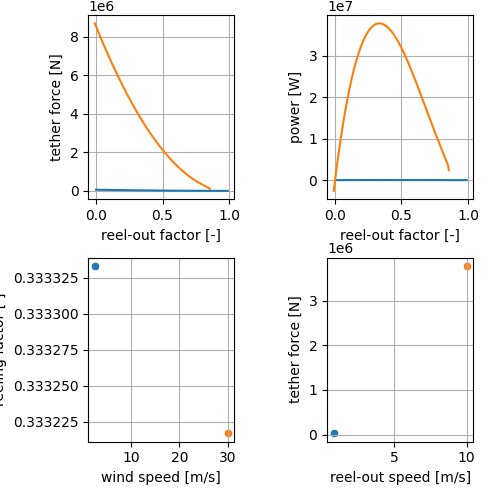

In [47]:
plt.close()
fig, axs = plt.subplots(2, 2, figsize=(5, 5))


def vrFtP_and_vrFt_plot(
    vw_mps,
    beta_deg,
    phi_deg,
    Lt_m,
    chi_deg,
    with_mass,
    # df_mass=df_mass,
    # df_mass_star=df_mass_star,
    # df_massless=df_massless,
    # df_massless_star = df_massless_star,
):

    # TODO: is it ok to access global variables like this? Would it be quicker if I didn't do that?
    df = df_mass if with_mass else df_massless
    df_star = df_mass_star if with_mass else df_massless_star

    f_min = -0.01 if with_mass else 0.0

    temp = df[
        (df["vw_mps"] == vw_mps)
        & (df["beta_deg"] == beta_deg)
        & (df["phi_deg"] == phi_deg)
        & (df["Lt_m"] == Lt_m)
        & (df["chi_deg"] == chi_deg)
        & (df["f"] >= f_min)
    ]

    temp_star = df_star[
        (df_star["vw_mps"] == vw_mps)
        & (df_star["beta_deg"] == beta_deg)
        & (df_star["phi_deg"] == phi_deg)
        & (df_star["Lt_m"] == Lt_m)
        & (df_star["chi_deg"] == chi_deg)
    ]

    # if temp.empty:
    #     raise Exception(
    #         f"df is empty with {vw_mps=} of type {type(vw_mps)}, {beta_deg=}, {phi_deg=}, {Lt_m=}, {chi_deg=}, {with_mass=}, {f_min=}"
    #     )
    # if temp_star.empty:
    #     raise Exception(
    #         f"df_star is empty with {vw_mps=}, {beta_deg=}, {phi_deg=}, {Lt_m=}, {chi_deg=}, {with_mass=}"
    #     )

    # Plot tether force and power output as function of reelout factor. Here we can see
    # that there's a certain optimum.
    for ax, y in zip(axs[0, :], ["Ftg_N", "P_W"]):
        sns.lineplot(data=temp, x="f", y=y, ax=ax, legend=False)

    # In the second row we only plot the ideal part of the curve.
    # Once ideal reelout factor per wind speed and the winch control curve (v_r, Ft).
    sns.scatterplot(data=temp_star, x="vw_mps", y="f_star", ax=axs[1, 0], legend=False)
    sns.scatterplot(
        data=temp_star, x="vr_mps_star", y="Ftg_N_star", ax=axs[1, 1], legend=False
    )


    # # No duplicate legend entries.
    # handles, labels = plt.gca().get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # plt.legend(by_label.values(), by_label.keys())


# Plot once to initialise the plot and set labels and the layout.
tic = time.time()
vrFtP_and_vrFt_plot(2.5, 0.0, 0.0, 500.0, 90.0, False)
toc = time.time()
# print(toc-tic)
set_labels(axs)
plt.tight_layout()
for ax_h in axs:
    for ax in ax_h:
        ax.grid()

# Make the interactive plot.
interact(vrFtP_and_vrFt_plot, **sliders)